# Analyze ULRs tweeted by US politicians

In [1]:
import pandas as pd
import numpy as np
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

import sys
sys.path.append('../../../../utilities/twitter_functions')
import twitter_functions as tf

In [195]:
# colors
demblue = "#0015BC"
repred = "#FF0000"
indgrey = "#696969"

ax_label_fontsize = 16
leg_label_fontsize = 14

## Massage data

In [107]:
src = "../../data/twitter"
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-16_clean.csv.gzip"
df = pd.read_csv(join(src, fname),
                 compression="gzip",
                 usecols=["id", "author_id", "created_at", "expanded_urls",
                          "retweeted", "quoted", "reply"])
df = df.drop_duplicates(subset="id")

/home/jana/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [108]:
df["expanded_urls"] = df["expanded_urls"].fillna("[]")
df["expanded_urls"] = df["expanded_urls"].apply(lambda x: eval(x))
df["has_url"] = df["expanded_urls"].apply(lambda x: len(x) > 0)

In [109]:
# expand the url lists into individual columns
urls = df['expanded_urls']\
    .apply(pd.Series)\
    .reset_index()\
    .melt(id_vars='index')\
    .dropna()[['index', 'value']]\
    .set_index('index')

In [110]:
urls = pd.merge(
    urls,
    df[['id']],
    left_index=True,
    right_index=True).rename(columns={'value_x': 'expanded_urls'})

df = pd.merge(df, urls, left_on="id", right_on="id", how="left")

df["N_urls"] = df["expanded_urls"].apply(lambda x: len(x))
df = df.rename(columns={"value":"url"})

df.to_csv(join(src, "combined_US_politician_twitter_timelines_2010-11-06_to_2021-03-16_clean_urls.csv.xz"),
          compression="xz", index=False)

## Import unraveled URLs

In [2]:
src = "../../data/twitter"
df = pd.read_csv(join(src, "combined_US_politician_twitter_timelines_2010-11-06_to_2021-03-16_clean_urls.csv.xz"),
          compression="xz")
df["id"] = df["id"].apply(lambda x: x.replace('"', ''))
df["author_id"] = df["author_id"].apply(lambda x: x.replace('"', ''))

In [3]:
unraveled_urls = pd.read_csv(join(src, "unraveled_urls.csv.xz"),
                             compression="xz")

In [4]:
# split into a table with and a table without URLs
no_urls = df[df["has_url"] == False].copy()
df = df[df["has_url"] == True]

In [5]:
# add URL information
df = pd.merge(df, unraveled_urls, left_on="url", right_on="url", how="left")

# add indicator of whether the URL was originally shortened
df["shortened"] = False
df.loc[df["unraveled_url"].dropna().index, "shortened"] = True

# replace the shortened URL with the unraveled URL
df.loc[df["unraveled_url"].dropna().index, "url"] = \
    df.loc[df["unraveled_url"].dropna().index, "unraveled_url"]
df = df.drop(columns=["unraveled_url"])

In [6]:
# extract the domain from the URL
df["domain"] = df["url"].apply(tf.extract_domain)

found malformed URL https
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http
found malformed URL http


## Find fishy domains with newsguard data

In [7]:
newsguard_src = "../../data/newsguard/newsguard_2022-03/03"
nutrition_labels = pd.read_csv(join(newsguard_src, "metadata-2022030100.csv"))

nutrition_labels = nutrition_labels\
    .sort_values(by=["Domain", "Last Updated"], ascending=False)
nutrition_labels = nutrition_labels.drop_duplicates(subset=["Domain"])

# threshold scores to create a "fishy" label
nutrition_labels["fishy"] = 0
nutrition_labels.loc[nutrition_labels[nutrition_labels["Score"] <= 25].index, "fishy"] = 1
fishy_domains = set(nutrition_labels[nutrition_labels["fishy"] == 1]["Domain"])

In [8]:
nutrition_cols = [
    "fishy", "Domain", "Rating", "Score", "Country", "Language", 
    "Does not repeatedly publish false content",
    "Gathers and presents information responsibly",
    "Regularly corrects or clarifies errors",
    "Handles the difference between news and opinion responsibly",
    "Avoids deceptive headlines",
    "Website discloses ownership and financing",
    "Clearly labels advertising",
    "Reveals who's in charge, including any possible conflicts of interest",
    "The site provides names of content creators, along with either contact or biographical information"
]
nutrition_categories = {col:f"C_{i}" for i, col in enumerate(nutrition_cols[6:])}

In [9]:
# add the nutrition information to the tweets
df = pd.merge(df, nutrition_labels[nutrition_cols],
         left_on="domain", right_on="Domain", how="left")

df = df.rename(columns=nutrition_categories)

# clean up the labels
for col in nutrition_categories.values():
    df[col] = df[col].replace({"Yes":0, "No":1})

## Count fishy domains in politician Tweets

In [10]:
N_shortened = len(df[(df["shortened"] == True)])
N_shortened_fishy = len(df[(df["shortened"] == True) & (df["fishy"] == 1)])
print("{}/{} ({:1.2f}%) shortened domains are fishy"\
      .format(N_shortened_fishy, N_shortened, 
              (N_shortened_fishy / N_shortened) * 100))

N_unshortened = len(df[(df["shortened"] == False)])
N_unshortened_fishy = len(df[(df["shortened"] == False) & (df["fishy"] == 1)])
print("{}/{} ({:1.2f}%) unshortened domains are fishy"\
      .format(N_unshortened_fishy, N_unshortened, 
              (N_unshortened_fishy / N_unshortened) * 100))

print("{}/{} ({:1.2f}%) of links are shortened"\
      .format(N_shortened, N_shortened + N_unshortened,
              (N_shortened / (N_shortened + N_unshortened)) * 100))

298/184223 (0.16%) shortened domains are fishy
1622/1706510 (0.10%) unshortened domains are fishy
184223/1890733 (9.74%) of links are shortened


In [11]:
# put the tweets with and without URLs back together
no_urls["shortened"] = False
no_urls["domain"] = np.nan
no_urls["fishy"] = 0
for col in nutrition_categories.values():
    no_urls[col] = 0
no_urls["Domain"] = np.nan
no_urls["Rating"] = np.nan
no_urls["Score"] = np.nan
no_urls["Language"] = np.nan
no_urls["Country"] = np.nan

all_tweets = pd.concat([df, no_urls])
del df
del no_urls

In [12]:
fishy_tweet_count = all_tweets[["id", "fishy"] + list(nutrition_categories.values())]\
    .groupby("id")\
    .sum()

In [13]:
N_tweets = len(fishy_tweet_count)
N_fishy_tweets = len(fishy_tweet_count[fishy_tweet_count["fishy"] > 0])
print("{}/{} ({:1.3f}%) tweets contain fishy urls"\
      .format(N_fishy_tweets, N_tweets, (N_fishy_tweets / N_tweets) * 100))

N_tweets = len(fishy_tweet_count)
N_C_0_tweets = len(fishy_tweet_count[fishy_tweet_count["C_0"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that repeatedly publishe false content"\
      .format(N_C_0_tweets, N_tweets, (N_C_0_tweets / N_tweets) * 100))

N_tweets = len(fishy_tweet_count)
N_C_1_tweets = len(fishy_tweet_count[fishy_tweet_count["C_1"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not represent information responsibly"\
      .format(N_C_1_tweets, N_tweets, (N_C_1_tweets / N_tweets) * 100))

N_tweets = len(fishy_tweet_count)
N_C_2_tweets = len(fishy_tweet_count[fishy_tweet_count["C_2"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not correct or clarify errors"\
      .format(N_C_2_tweets, N_tweets, (N_C_2_tweets / N_tweets) * 100))

N_tweets = len(fishy_tweet_count)
N_C_3_tweets = len(fishy_tweet_count[fishy_tweet_count["C_3"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not handle differences between news and opinion responsibly"\
      .format(N_C_3_tweets, N_tweets, (N_C_3_tweets / N_tweets) * 100))

N_tweets = len(fishy_tweet_count)
N_C_4_tweets = len(fishy_tweet_count[fishy_tweet_count["C_4"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that use deceptive headlines"\
      .format(N_C_4_tweets, N_tweets, (N_C_4_tweets / N_tweets) * 100))

N_tweets = len(fishy_tweet_count)
N_C_5_tweets = len(fishy_tweet_count[fishy_tweet_count["C_5"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not disclose ownership and financing"\
      .format(N_C_5_tweets, N_tweets, (N_C_5_tweets / N_tweets) * 100))

N_tweets = len(fishy_tweet_count)
N_C_6_tweets = len(fishy_tweet_count[fishy_tweet_count["C_6"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not clearly label advertising"\
      .format(N_C_6_tweets, N_tweets, (N_C_6_tweets / N_tweets) * 100))

N_tweets = len(fishy_tweet_count)
N_C_7_tweets = len(fishy_tweet_count[fishy_tweet_count["C_7"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not reveal person in charge"\
      .format(N_C_7_tweets, N_tweets, (N_C_7_tweets / N_tweets) * 100))

N_tweets = len(fishy_tweet_count)
N_C_8_tweets = len(fishy_tweet_count[fishy_tweet_count["C_8"] > 0])
print("{}/{} ({:1.3f}%) tweets contain urls to domains that do not reveal names of content creators"\
      .format(N_C_8_tweets, N_tweets, (N_C_8_tweets / N_tweets) * 100))

1909/2588559 (0.074%) tweets contain fishy urls
2440/2588559 (0.094%) tweets contain urls to domains that repeatedly publishe false content
30452/2588559 (1.176%) tweets contain urls to domains that do not represent information responsibly
34815/2588559 (1.345%) tweets contain urls to domains that do not correct or clarify errors
45043/2588559 (1.740%) tweets contain urls to domains that do not handle differences between news and opinion responsibly
1647/2588559 (0.064%) tweets contain urls to domains that use deceptive headlines
63290/2588559 (2.445%) tweets contain urls to domains that do not disclose ownership and financing
29668/2588559 (1.146%) tweets contain urls to domains that do not clearly label advertising
33505/2588559 (1.294%) tweets contain urls to domains that do not reveal person in charge
31869/2588559 (1.231%) tweets contain urls to domains that do not reveal names of content creators


In [14]:
fishy_user_count = all_tweets[["author_id", "fishy"] + list(nutrition_categories.values())]\
    .groupby("author_id")\
    .agg(["sum", "count"])

In [15]:
fishy_user_count.head(2)

fishy        C_0        C_1         C_2        C_3        \
                      sum count  sum count  sum count   sum count  sum count   
author_id                                                                      
1009269193            0.0  1578  0.0  1558  1.0  1558  49.0  1558  5.0  1557   
1011053278304591872   0.0    15  0.0    15  0.0    15   0.0    15  0.0    15   

                     C_4         C_5         C_6         C_7         C_8        
                     sum count   sum count   sum count   sum count   sum count  
author_id                                                                       
1009269193           0.0  1558  74.0  1558  12.0  1505  19.0  1558  23.0  1558  
1011053278304591872  0.0    15   0.0    15   0.0    15   0.0    15   1.0    15

In [16]:
fishy_user_count["share"] = fishy_user_count["fishy"]["sum"] / \
                            fishy_user_count["fishy"]["count"]

for col in nutrition_categories.values():
    fishy_user_count[f"{col}_share"] = fishy_user_count[col]["sum"] / \
                                       fishy_user_count[col]["count"]

In [17]:
N_no_shares = len(fishy_user_count[fishy_user_count["share"] == 0])
print(f"{N_no_shares}/{len(fishy_user_count)} did not share any fishy links")

max_share = fishy_user_count["share"].max()
print("the most fishy user has {:1.2f}% tweets with fishy links"\
      .format(max_share * 100))

719/1035 did not share any fishy links
the most fishy user has 4.10% tweets with fishy links


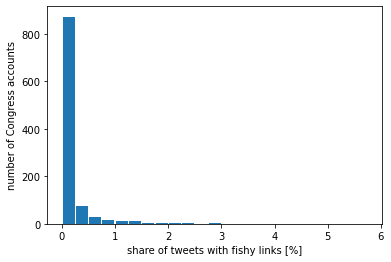

In [18]:
fig, ax = plt.subplots()
ax.hist(fishy_user_count["share"] * 100, 
        bins=np.arange(0, 6, 0.25), rwidth=0.9)
ax.set_xlabel("share of tweets with fishy links [%]")
ax.set_ylabel("number of Congress accounts")
plt.savefig("fishy_share.png")

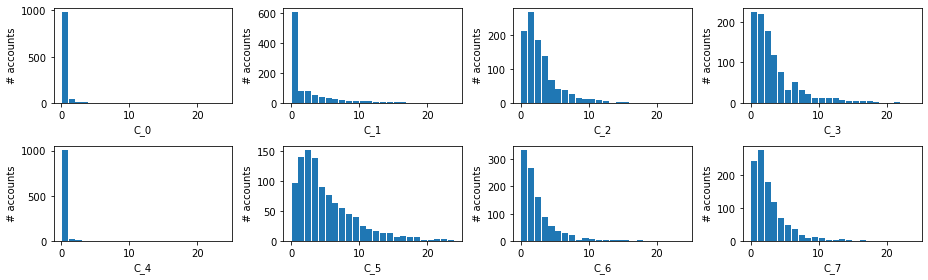

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(13, 4))
for ax, col in zip(axes.flatten(), nutrition_categories.values()):
    ax.hist(fishy_user_count[f"{col}_share"] * 100, 
            bins=np.arange(0, 25, 1), rwidth=0.9)
    ax.set_xlabel(col)
    ax.set_ylabel("# accounts")
fig.tight_layout()

In [20]:
fishy_user_count = fishy_user_count.reset_index()
fishy_user_count.columns = ['_'.join(col).strip("_") \
                            for col in fishy_user_count.columns.values]

## Add party affiliation to the mix

In [21]:
# author IDs have become converted to floats / integers and lost the last 4
# digits. We have a list of the correct IDs stored as strings and use it to
# match the corrupted IDs back to the correct ones based on the first 13 digits
# of the IDs

ids = np.loadtxt(join(src, "correct_author_ids.txt"))
ids = pd.DataFrame({"id":ids}).sort_values(by="id")
ids["id"] = ids["id"].astype(int).astype(str)
partial_ids = ids[ids["id"].apply(lambda x: len(x) >=14)].copy()
partial_ids["id_part"] = partial_ids["id"].apply(lambda x: x[0:13])
partial_ids = {row["id_part"]:row["id"] for i, row in partial_ids.iterrows()}

def match_id(old_id):
    if len(old_id) > 16:
        id_part = old_id[0:13]
        if id_part in partial_ids.keys():
            correct_id = partial_ids[id_part]
            return correct_id
    return old_id

## Make a user data frame

In [22]:
# load party affiliation, strip " used to ensure author_ids are stored as
# strings and not numbers
party_affiliation = pd.read_csv(join(src, "party_affiliations_complete.csv"))
party_affiliation["author_id"] = party_affiliation["author_id"]\
    .apply(lambda x: x.replace('"', ''))

party_affiliation["author_id"] = party_affiliation["author_id"].apply(match_id)
fishy_user_count["author_id"] = fishy_user_count["author_id"].apply(match_id)

# merge fishy link information and information about party affiliation
user_df = pd.merge(
    fishy_user_count, 
    party_affiliation, 
    how="left", 
    left_on="author_id",
    right_on="author_id"
).copy()

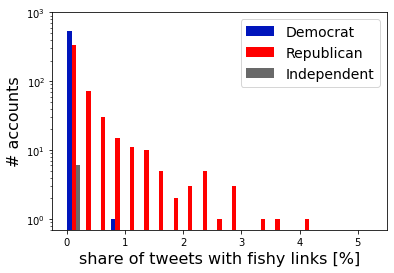

In [198]:
fig, ax = plt.subplots()
dem = user_df[user_df["party"] == "Democrat"]
rep = user_df[user_df["party"] == "Republican"]
ind = user_df[user_df["party"] == "Independent"]
ax.hist([dem["share"] * 100, rep["share"] * 100, ind["share"] * 100], 
        bins=np.arange(0, 5.5, 0.25), rwidth=0.9, 
        label=["Democrat", "Republican", "Independent"],
        color=[demblue, repred, indgrey])
ax.set_xlabel("share of tweets with fishy links [%]",
              fontsize=ax_label_fontsize)
ax.set_ylabel("# accounts", fontsize=ax_label_fontsize)
ax.legend(fontsize=leg_label_fontsize)
ax.set_ylim(0.7, 1e3)
ax.set_yscale('log')
plt.savefig("../../plots/fishy_share.pdf")

In [24]:
nut_cat_dict = {
    "C_0":"repeatedly publishes false information",
    "C_1":"doesn't gather and present\ninformation responsibly",
    "C_2":"doesn't regularly correct\nor clarify errors",
    "C_3":"doesn't handle the difference\nbetween news and opinion responsibly",
    "C_4":"uses deceptive headlines",
    "C_5":"doesn't disclose website\nownership and financing",
    "C_6":"doesn't label advertising",
    "C_7":"doesn't reveal conflicts\nof interest and who is in charge",
    "C_8":"doesn't provide names and\nbios of content creators"
}

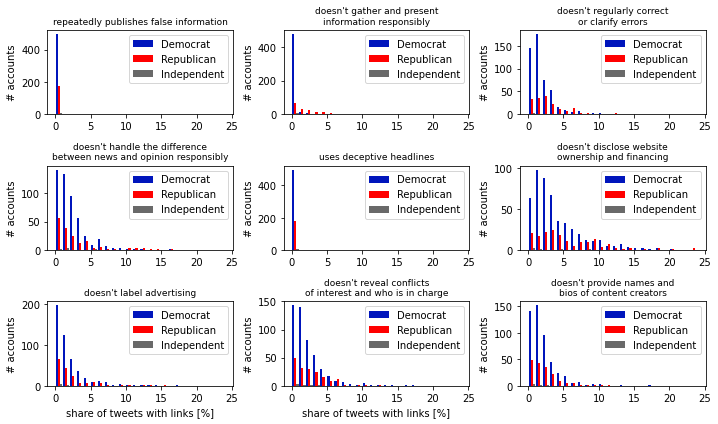

In [222]:
fig, axes = plt.subplots(3, 3, figsize=(10, 6))
for ax, col, i in zip(axes.flatten(),
                      nutrition_categories.values(),
                      range(len(axes.flatten()))):
    ax.hist([dem[f"{col}_share"] * 100,
             rep[f"{col}_share"] * 100,
             ind[f"{col}_share"] * 100], 
            bins=np.arange(0, 25, 1), rwidth=0.9,
            label=["Democrat", "Republican", "Independent"],
            color=[demblue, repred, indgrey])
    ax.set_title(nut_cat_dict[col], fontsize=9)
    if i in [6, 7]:
        ax.set_xlabel("share of tweets with links [%]")
    ax.set_ylabel("# accounts")
    ax.legend()
fig.tight_layout()
plt.savefig("../../plots/nutrition_label_share.pdf")

In [215]:
ttest_ind(dem["share"], rep["share"])

Ttest_indResult(statistic=-0.24454362057901827, pvalue=0.8068843605218261)

In [27]:
for col in nutrition_categories.values():
    print(ttest_ind(dem[f"{col}_share"], rep[f"{col}_share"]))

Ttest_indResult(statistic=-13.132200900552899, pvalue=1.595812668041467e-36)
Ttest_indResult(statistic=-20.540591187037318, pvalue=8.547852676893419e-79)
Ttest_indResult(statistic=-11.534689674817102, pvalue=5.000857552260731e-29)
Ttest_indResult(statistic=-11.618477594887432, pvalue=2.1074832115362343e-29)
Ttest_indResult(statistic=-11.027019704060018, pvalue=8.48255203913216e-27)
Ttest_indResult(statistic=-6.738743277740193, pvalue=2.6606350302044586e-11)
Ttest_indResult(statistic=-2.23072908075793, pvalue=0.025914836142809834)
Ttest_indResult(statistic=-3.69694602894095, pvalue=0.0002297709984034977)
Ttest_indResult(statistic=-5.344527071100951, pvalue=1.1171772022965445e-07)


In [28]:
all_tweets[all_tweets["fishy"] == 1]["Domain"].value_counts()[0:10]

thefederalist.com       703
newsmax.com             638
oann.com                108
thenationalpulse.com     91
thehayride.com           40
revolver.news            39
lifesitenews.com         39
wnd.com                  27
warroom.org              24
zerohedge.com            20
Name: Domain, dtype: int64

## Add ideology scores

In [29]:
fname = "govtrack-stats-{}-{}-ideology.csv"
scores = pd.DataFrame()
for year in range(2013, 2021):
    for chamber in ["house", "senate"]:
        tmp = pd.read_csv(join(src, "ideology_scores",
                               fname.format(year, chamber)))
        tmp["year"] = year
        tmp["name"] = tmp["name"].apply(lambda x: x.replace("b'", ""))
        tmp["name"] = tmp["name"].apply(lambda x: x.replace("'", "").lower())
        scores = pd.concat([scores, tmp])

In [30]:
counts = scores["name"].value_counts()
# a single politician can have at maximum 8 entries for 8 different years
# 2013 to 2020
unique_names = list(counts[counts <= 8].index)

unique_scores = scores[scores["name"].isin(unique_names)]\
    .sort_values(by="year", ascending=False)\
    .drop_duplicates(subset=["name"])\
    .set_index("name")
unique_names = list(set(unique_scores.index))

def match_score(account_name):
    if account_name == account_name:
        account_name = set(account_name.lower().split(" "))
        for name in unique_names:
            if name in account_name:
                return unique_scores.loc[name]["id"]
    else:
        return np.nan
    
user_df["ideology_score_id"] = user_df["name"].apply(match_score)

In [31]:
# add hand-matched missing scores
missing_scores = pd.read_csv(join(src, "missing_scores.csv"))
missing_scores = {row["handle"]:row["ideology_score_id"] \
                  for i, row in missing_scores.iterrows()}

# merge on the handle since this seems to be the most consistent index between
# the two datasets
user_df = user_df.set_index("handle")
for handle, score_id in missing_scores.items():
    user_df.loc[handle, "ideology_score_id"] = score_id
    
user_df = user_df.reset_index()

In [32]:
# for many accounts, there is more than one ideology score since they were 
# active over many years. We calculate the mean, std and count of the ideology
# score for each user and add this information to the user_df
scores_agg = scores[["id", "ideology"]]\
    .groupby("id")\
    .agg(["mean", "std", "count"])
scores_agg = scores_agg.reset_index()
scores_agg.columns = ['_'.join(col).strip("_") \
                            for col in scores_agg.columns.values]

user_df = user_df.merge(scores_agg, how="left", 
                      left_on="ideology_score_id", right_on="id")

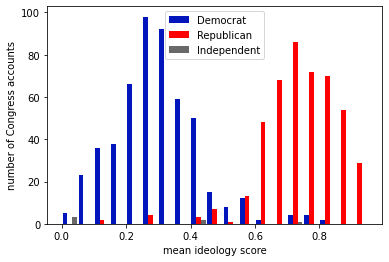

In [206]:
fig, ax = plt.subplots()
dem = user_df[user_df["party"] == "Democrat"]
rep = user_df[user_df["party"] == "Republican"]
ind = user_df[user_df["party"] == "Independent"]
ax.hist([dem["ideology_mean"], rep["ideology_mean"], ind["ideology_mean"]], 
        bins=np.arange(0, 1, 0.05), rwidth=0.9, 
        label=["Democrat", "Republican", "Independent"],
        color=[demblue, repred, indgrey])
ax.set_xlabel("mean ideology score")
ax.set_ylabel("number of Congress accounts")
ax.legend()
plt.savefig("../../plots/ideology_scores.pdf")

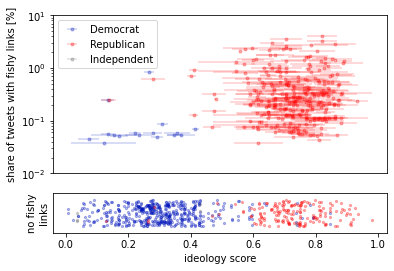

In [207]:
from matplotlib.gridspec import GridSpec
fig = plt.figure()
gs = GridSpec(2, 1, height_ratios=[4, 1])
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

subset = user_df.dropna(subset=["ideology_mean", "share"])
dem = subset[subset["party"] == "Democrat"]
rep = subset[subset["party"] == "Republican"]
ind = subset[subset["party"] == "Independent"]

stuff = ax.errorbar(dem["ideology_mean"], dem["share"] * 100, fmt='o',
           xerr=dem["ideology_std"], color=demblue,
           label="Democrat", alpha=0.3, ms=3)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]

stuff = ax.errorbar(rep["ideology_mean"], rep["share"] * 100, fmt='o',
           xerr=rep["ideology_std"], color=repred,
           label="Republican", alpha=0.3, ms=3)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]

stuff = ax.errorbar(ind["ideology_mean"], ind["share"] * 100, fmt='o',
           xerr=ind["ideology_std"], color=indgrey,
           label="Independent", alpha=0.3, ms=3)
markers, caps, bars = stuff
[bar.set_alpha(0.2) for bar in bars]

ax.legend()
ax.set_yscale('log')
ax.set_ylabel("share of tweets with fishy links [%]")
ax.set_ylim(1e-2, 1e1)
ax.set_xticks([])

subsubset = subset[subset["share"] == 0].copy()
subsubset["share"] = subsubset["share"]\
    .apply(lambda x: x + np.random.rand() * 2 - 1)
dem = subsubset[subsubset["party"] == "Democrat"]
rep = subsubset[subsubset["party"] == "Republican"]
ind = subsubset[subsubset["party"] == "Independent"]


ax2.scatter(dem["ideology_mean"], dem["share"], color=demblue, alpha=0.3,
            label="Democrat", s=5)
ax2.scatter(rep["ideology_mean"], rep["share"], color=repred, alpha=0.3,
            label="Republican", s=5)
ax2.scatter(ind["ideology_mean"], ind["share"], color=indgrey, alpha=0.3,
            label="Independent", s=5)

ax2.set_yticks([])
ax2.set_xlabel("ideology score")
ax2.set_ylim([-1.5, 1.5])
ax2.set_ylabel("no fishy\nlinks")
plt.savefig("../../plots/ideology_scores_and_fishy_links.pdf")

## Add truth seeking & belief speaking scores

In [35]:
src = "../../data/twitter"

In [145]:
! rsync -avze ssh jlasser@medea:/data/honesty/corpora/Twitter/combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-16_threshold_label.csv ../../data/twitter/combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-16_threshold_label.csv --progress

receiving incremental file list

sent 20 bytes  received 138 bytes  105.33 bytes/sec
total size is 667,007,968  speedup is 4,221,569.42


In [36]:
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-16_threshold_label.csv"
cols = ["id", "author_id", "belief_label", "truth_label", "understanding_label"]
honesty_tweets = pd.read_csv(join(src, fname), usecols=cols)

honesty_tweets["author_id"] = honesty_tweets["author_id"].apply(lambda x: x.replace('"', ''))
honesty_tweets["id"] = honesty_tweets["id"].apply(lambda x: x.replace('"', ''))
honesty_tweets = honesty_tweets.rename(columns={
    "belief_label":"belief",
    "truth_label":"truth",
    "understanding_label":"understanding"})

### User-level analysis

In [37]:
honesty_label_count = honesty_tweets[["author_id", "belief", "truth", "understanding"]]\
    .groupby("author_id")\
    .agg(["sum", "count"])

for col in ["belief", "truth", "understanding"]:
    honesty_label_count[f"{col}_share"] = honesty_label_count[col]["sum"] / \
    honesty_label_count[col]["count"]
    
honesty_label_count.columns = ['_'.join(col).strip("_") \
                            for col in honesty_label_count.columns.values]
honesty_label_count = honesty_label_count.reset_index()
honesty_label_count["author_id"] = honesty_label_count["author_id"].apply(match_id)

In [38]:
user_df = user_df.merge(honesty_label_count, how="left", left_on="author_id", 
             right_on="author_id")

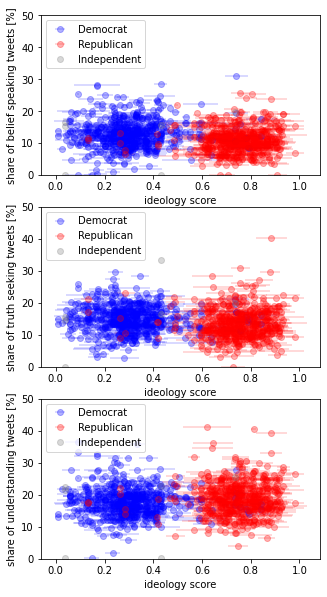

In [39]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
dem = user_df[user_df["party"] == "Democrat"]
rep = user_df[user_df["party"] == "Republican"]
ind = user_df[user_df["party"] == "Independent"]

for ax, col, label in zip(axes.flatten(), 
        ["belief_share", "truth_share", "understanding_share"],
        ["belief speaking", "truth seeking", "understanding"]):
    stuff = ax.errorbar(dem["ideology_mean"], dem[col] * 100 + 0.1, fmt='o',
               xerr=dem["ideology_std"], color='b',
               label="Democrat", alpha=0.3)
    markers, caps, bars = stuff
    [bar.set_alpha(0.2) for bar in bars]

    stuff = ax.errorbar(rep["ideology_mean"], rep[col] * 100 + 0.1, fmt='o',
               xerr=rep["ideology_std"], color='r', label="Republican", alpha=0.3)
    markers, caps, bars = stuff
    [bar.set_alpha(0.2) for bar in bars]

    stuff = ax.errorbar(ind["ideology_mean"], ind[col] * 100 + 0.1, fmt='o',
               color='grey', label="Independent", alpha=0.3)
    markers, caps, bars = stuff
    [bar.set_alpha(0.2) for bar in bars]

    ax.legend(loc=2)
    ax.set_xlabel("ideology score")
    ax.set_ylabel(f"share of {label} tweets [%]")
    ax.set_ylim(0, 50)
plt.savefig("../../plots/ideology_and_honesty_labels.pdf")

### Tweet-level analysis

In [40]:
len(honesty_tweets)

1824800

In [277]:
original_tweets = all_tweets[all_tweets["retweeted"] == False]#.drop_duplicates(subset=["id"])

In [278]:
len(original_tweets)

2324378

In [279]:
tweet_df = pd.merge(honesty_tweets[["id", "belief", "truth", "understanding"]], 
         original_tweets, how="right", left_on="id", right_on="id")

In [280]:
len(tweet_df)

2324378

In [46]:
#tweet_df["belief"] = tweet_df["belief"].fillna(0)
#tweet_df["truth"] = tweet_df["truth"].fillna(0)
#tweet_df["understanding"] = tweet_df["understanding"].fillna(0)

In [281]:
tweets_with_urls = tweet_df[tweet_df["has_url"] == True]

In [282]:
len(tweets_with_urls["belief"].dropna())

1611219

In [283]:
len(tweets_with_urls)

1787962

In [241]:
N_bootstrap = 100
cols = ["fishy"] + [f"C_{i}" for i in range(0, 9)]
bootstrap_results = pd.DataFrame()
for i in range(N_bootstrap):
    if i%10 == 0:
        print(i)
    tweet_sample = tweets_with_urls.sample(len(tweets_with_urls), replace=True)
    row = {}
    for col in cols:
        agg = tweet_sample[[col] + ["belief", "truth", "understanding"]]\
                .groupby(col).agg(sum)
        res = agg.loc[1] / agg.loc[0]
        for comp in ["belief", "truth", "understanding"]:
            bootstrap_results = bootstrap_results.append({
                "misinfo_label":col,
                "honesty_component":comp,
                "percentage":res[comp]
            }, ignore_index=True)

0
10
20
30
40
50
60
70
80
90


In [264]:
N_bootstrap = 100
cols = ["fishy"] + [f"C_{i}" for i in range(0, 9)]
dem = tweets_with_urls[tweets_with_urls["party"] == "Democrat"]
bootstrap_results_dem = pd.DataFrame()
for i in range(N_bootstrap):
    if i%10 == 0:
        print(i)
    tweet_sample = dem.sample(len(dem), replace=True)
    row = {}
    for col in cols:
        agg = tweet_sample[[col] + ["belief", "truth", "understanding"]]\
                .groupby(col).agg(sum)
        res = agg.loc[1] / agg.loc[0]
        for comp in ["belief", "truth", "understanding"]:
            bootstrap_results_dem = bootstrap_results_dem.append({
                "misinfo_label":col,
                "honesty_component":comp,
                "percentage":res[comp]
            }, ignore_index=True)

0
10
20
30
40
50
60
70
80
90


In [265]:
N_bootstrap = 100
cols = ["fishy"] + [f"C_{i}" for i in range(0, 9)]
rep = tweets_with_urls[tweets_with_urls["party"] == "Republican"]
bootstrap_results_rep = pd.DataFrame()
for i in range(N_bootstrap):
    if i%10 == 0:
        print(i)
    tweet_sample = rep.sample(len(rep), replace=True)
    row = {}
    for col in cols:
        agg = tweet_sample[[col] + ["belief", "truth", "understanding"]]\
                .groupby(col).agg(sum)
        res = agg.loc[1] / agg.loc[0]
        for comp in ["belief", "truth", "understanding"]:
            bootstrap_results_rep = bootstrap_results_rep.append({
                "misinfo_label":col,
                "honesty_component":comp,
                "percentage":res[comp]
            }, ignore_index=True)

0
10
20
30
40
50
60
70
80
90


In [242]:
import itertools

In [243]:
list(itertools.combinations(["belief", "truth", "understanding"], 2))

[('belief', 'truth'), ('belief', 'understanding'), ('truth', 'understanding')]

In [244]:
bootstrap_results["percentage"] = bootstrap_results["percentage"] * 100

In [245]:
nut_cat_dict["fishy"] = "score <= 25"

In [255]:
len(tweets_with_urls)

1499251

In [257]:
tweets_with_urls = pd.merge(tweets_with_urls, user_df[["author_id", "party"]],
         how="left", left_on="author_id", right_on="author_id")

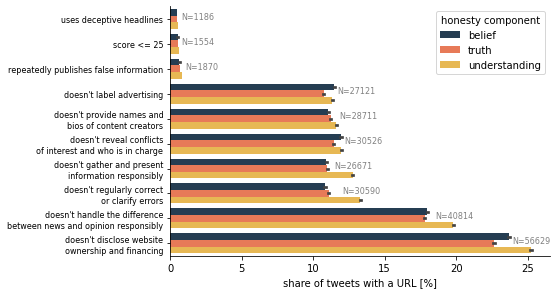

In [248]:
order = ["C_4", "fishy", "C_0", "C_6", "C_8", "C_7",
         "C_1", "C_2", "C_3", "C_5"]
palette = ["#1e3d59", "#ff6e40", "#ffc13b"]
g = sns.catplot(x="percentage", y="misinfo_label",
                hue="honesty_component",
                data=bootstrap_results, kind="bar",
                height=4, aspect=1.5, order=order,
                legend_out=False, palette=palette);
g.ax.set_ylabel("")
g.ax.set_xlabel("share of tweets with a URL [%]")
yticklabels = [nut_cat_dict[lab] for lab in order]
g.ax.set_yticklabels(yticklabels, fontsize=8)
g.ax.legend().set_title("honesty component")

for col, y in zip(order, range(0, 10)):
    col_data = bootstrap_results[bootstrap_results["misinfo_label"] == col]
    x = col_data[["honesty_component", "percentage"]]\
        .groupby("honesty_component")\
        .agg("mean").max()["percentage"]
    N = int(tweets_with_urls[col].sum())
    if col in order[-4:]:
        mod = -1.3
    else:
        mod = 0.2
    g.ax.text(x + mod, y, f"N={N}", fontsize=8, color="grey")
fig.tight_layout()
plt.savefig("../../plots/fishy_links_and_honesty_components.png",
            bbox_inches="tight", facecolor="white")

In [274]:
bootstrap_results_dem["party"] = "dem"
bootstrap_results_rep["party"] = "rep"
bootstrap_results_party = pd.concat([bootstrap_results_dem,
                                     bootstrap_results_rep])\
    .reset_index(drop=True)
bootstrap_results_party["percentage"] = bootstrap_results_party["percentage"] * 100

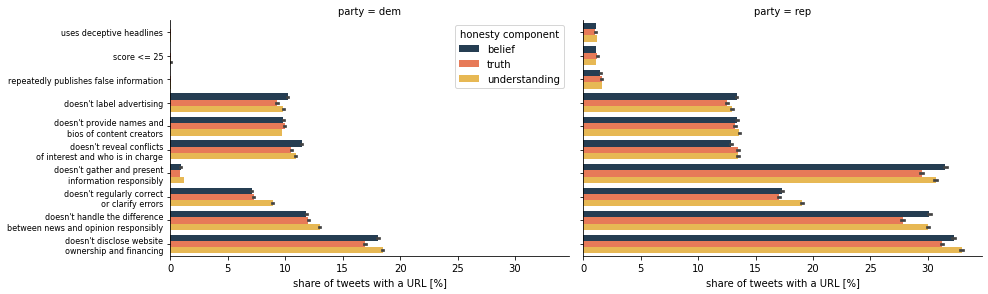

In [276]:
order = ["C_4", "fishy", "C_0", "C_6", "C_8", "C_7",
         "C_1", "C_2", "C_3", "C_5"]
palette = ["#1e3d59", "#ff6e40", "#ffc13b"]
g = sns.catplot(x="percentage", y="misinfo_label",
                hue="honesty_component", col="party",
                data=bootstrap_results_party, kind="bar",
                height=4, aspect=1.5, order=order,
                legend_out=False, palette=palette);
g.axes[0][0].set_ylabel("")
g.axes[0][0].set_ylabel("")
g.axes[0][0].set_xlabel("share of tweets with a URL [%]")
g.axes[0][1].set_xlabel("share of tweets with a URL [%]")
yticklabels = [nut_cat_dict[lab] for lab in order]
g.axes[0][0].set_yticklabels(yticklabels, fontsize=8)
g.axes[0][0].legend().set_title("honesty component")

fig.tight_layout()
plt.savefig("../../plots/fishy_links_and_honesty_components_partysplit.png",
            bbox_inches="tight", facecolor="white")

In [258]:
dem = tweets_with_urls[tweets_with_urls["party"] == "Democrat"]
rep = tweets_with_urls[tweets_with_urls["party"] == "Republican"]

In [263]:
belief_mean = dem[dem["belief"] == True]["Score"].mean()
belief_std = dem[dem["belief"] == True]["Score"].std()
truth_mean = dem[dem["truth"] == True]["Score"].mean()
truth_std = dem[dem["truth"] == True]["Score"].std()
understanding_mean = dem[dem["understanding"] == True]["Score"].mean()
understanding_std = dem[dem["understanding"] == True]["Score"].std()
print("belief: {:1.2f} +- {:1.2f}".format(belief_mean, belief_std))
print("truth: {:1.2f} +- {:1.2f}".format(truth_mean, truth_std))
print("understanding: {:1.2f} +- {:1.2f}".format(understanding_mean, understanding_std))

belief: 94.93 +- 7.95
truth: 95.05 +- 7.98
understanding: 94.59 +- 8.30


In [262]:
belief_mean = rep[rep["belief"] == True]["Score"].mean()
belief_std = rep[rep["belief"] == True]["Score"].std()
truth_mean = rep[rep["truth"] == True]["Score"].mean()
truth_std = rep[rep["truth"] == True]["Score"].std()
understanding_mean = rep[rep["understanding"] == True]["Score"].mean()
understanding_std = rep[rep["understanding"] == True]["Score"].std()
print("belief: {:1.2f} +- {:1.2f}".format(belief_mean, belief_std))
print("truth: {:1.2f} +- {:1.2f}".format(truth_mean, truth_std))
print("understanding: {:1.2f} +- {:1.2f}".format(understanding_mean, understanding_std))

belief: 86.66 +- 15.76
truth: 87.12 +- 15.83
understanding: 86.55 +- 15.87


## Belief-speaking-vs-truth-seeking index

In [117]:
user_df

,handle,author_id,fishy_sum,fishy_count,C_0_sum,C_0_count,C_1_sum,C_1_count,C_2_sum,C_2_count,...,ideology_count,belief_sum,belief_count,truth_sum,truth_count,understanding_sum,understanding_count,belief_share,truth_share,understanding_share
0,RepLipinski,1009269193,0.0,1578,0.0,1558,1.0,1558,49.0,1558,...,8.0,262.0,2585.0,489.0,2585.0,615.0,2585.0,0.101354,0.189168,0.237911
1,CaptClayHiggins,1011053278304592000,0.0,15,0.0,15,0.0,15,0.0,15,...,8.0,1.0,13.0,3.0,13.0,2.0,13.0,0.076923,0.230769,0.153846
2,SenBillCassidy,1017500185356852992,5.0,1971,6.0,1946,78.0,1946,97.0,1946,...,8.0,368.0,2731.0,482.0,2731.0,502.0,2731.0,0.134749,0.176492,0.183815
3,RepWexton,1017819745880542976,0.0,1308,0.0,1290,4.0,1290,85.0,1290,...,2.0,417.0,3027.0,641.0,3027.0,734.0,3027.0,0.137760,0.211761,0.242484
4,AugustPfluger,1021216905795899008,0.0,981,0.0,974,194.0,974,108.0,974,...,NaN,212.0,1736.0,272.0,1736.0,283.0,1736.0,0.122120,0.156682,0.163018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030,jeffsessions,986781648,5.0,929,5.0,911,83.0,911,67.0,911,...,4.0,206.0,1057.0,216.0,1057.0,276.0,1057.0,0.194891,0.204352,0.261116
1031,JahanaHayesCT,991721030631780352,0.0,623,0.0,613,0.0,613,11.0,613,...,2.0,138.0,849.0,120.0,849.0,170.0,849.0,0.162544,0.141343,0.200236
1032,RodneyDavis,993153006,1.0,1633,1.0,1551,25.0,1551,29.0,1551,...,8.0,232.0,2281.0,383.0,2281.0,501.0,2281.0,0.101710,0.167909,0.219641
1033,RepDelBene,995193054,0.0,1967,0.0,1938,1.0,1938,23.0,1938,...,8.0,329.0,2913.0,467.0,2913.0,471.0,2913.0,0.112942,0.160316,0.161689


0       0.651132
3       0.605860
5       1.000000
8       0.580815
11      0.477513
          ...   
1021    0.535168
1023    0.456000
1027    0.730159
1031    0.465116
1033    0.586683
Length: 530, dtype: float64

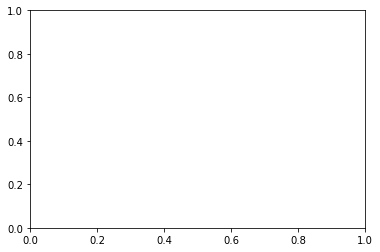

In [122]:
dem = user_df[user_df["party"] == "Democrat"]
rep = user_df[user_df["party"] == "Republican"]
ind = user_df[user_df["party"] == "Independent"]

fig, ax = plt.subplots()
dem["truth_sum"] / (dem["belief_sum"] + dem["truth_sum"])
ax.scatter()

In [119]:
dem

,handle,author_id,fishy_sum,fishy_count,C_0_sum,C_0_count,C_1_sum,C_1_count,C_2_sum,C_2_count,...,ideology_count,belief_sum,belief_count,truth_sum,truth_count,understanding_sum,understanding_count,belief_share,truth_share,understanding_share
0,RepLipinski,1009269193,0.0,1578,0.0,1558,1.0,1558,49.0,1558,...,8.0,262.0,2585.0,489.0,2585.0,615.0,2585.0,0.101354,0.189168,0.237911
3,RepWexton,1017819745880542976,0.0,1308,0.0,1290,4.0,1290,85.0,1290,...,2.0,417.0,3027.0,641.0,3027.0,734.0,3027.0,0.137760,0.211761,0.242484
5,DickBlumenthal,102477372,0.0,6,0.0,6,0.0,6,0.0,6,...,8.0,0.0,11.0,2.0,11.0,4.0,11.0,0.000000,0.181818,0.363636
8,RepMarkTakano,1037321378,0.0,1812,0.0,1798,3.0,1798,11.0,1798,...,8.0,319.0,2468.0,442.0,2468.0,463.0,2468.0,0.129254,0.179092,0.187601
11,RepDanKildee,1045110018,0.0,1606,0.0,1566,13.0,1566,61.0,1566,...,8.0,395.0,2681.0,361.0,2681.0,500.0,2681.0,0.147333,0.134651,0.186498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,ReElectHank,97583689,0.0,867,0.0,837,8.0,837,30.0,837,...,8.0,152.0,1242.0,175.0,1242.0,193.0,1242.0,0.122383,0.140902,0.155395
1023,votemorelle,977247448820305920,0.0,98,0.0,97,0.0,97,3.0,97,...,3.0,68.0,440.0,57.0,440.0,66.0,440.0,0.154545,0.129545,0.150000
1027,RepConorLamb,984456621417000960,0.0,114,0.0,112,0.0,112,4.0,112,...,3.0,51.0,666.0,138.0,666.0,114.0,666.0,0.076577,0.207207,0.171171
1031,JahanaHayesCT,991721030631780352,0.0,623,0.0,613,0.0,613,11.0,613,...,2.0,138.0,849.0,120.0,849.0,170.0,849.0,0.162544,0.141343,0.200236
